# Working with Alert Packets

We start by familiarizing ourselves with (ZTF) alert packets.

In ZTF, these stored as [Avro](https://avro.apache.org/) files. But (as you'll soon see), the serialization doesn't matter as much once they're loaded as Python structures.

In [1]:
import os
import io
import gzip
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging

import fastavro

from astropy.time import Time
from astropy.io import fits
from pprint import pprint
import aplpy
%matplotlib inline

### Loading from files

A handful of sample alerts are available in the [ztf-avro-alert](https://github.com/ZwickyTransientFacility/ztf-avro-alert) repository, which also [documents](https://zwickytransientfacility.github.io/ztf-avro-alert/schema.html) the packet contents. I've also copied a few here, for simplicity.

In [2]:
DATA_DIR = './data/'

Let's count packets. Let's use a generator--we could eventually have millions of these alerts to look at!

In [3]:
def find_files(root_dir):
    for dir_name, subdir_list, file_list in os.walk(root_dir, followlinks=True):
        for fname in file_list:
            if fname.endswith('.avro'):
                yield dir_name+'/'+fname

In [4]:
print('{} has {} avro files'.format(DATA_DIR, len(list(find_files(DATA_DIR)))))

./data/ has 2 avro files


Let's grab the first file and look at it

In [5]:
files_gen = find_files(DATA_DIR)
fname = next(files_gen)

In [6]:
fname

'./data//2019_01_10_739260766315010006.avro'

Let's load the alert using the `fastavro` package:

In [7]:
%%time 
with open(fname,'rb') as f:
    freader = fastavro.reader(f)
    schema = freader.writer_schema

    for packet in freader:
        print(packet.keys())

dict_keys(['schemavsn', 'publisher', 'objectId', 'candid', 'candidate', 'prv_candidates', 'cutoutScience', 'cutoutTemplate', 'cutoutDifference'])
CPU times: user 4.18 ms, sys: 3.61 ms, total: 7.79 ms
Wall time: 6.87 ms


Each Avro packet has a schema, and the content conforming to the schema. In Python, these are represented as nested dictionaries.

Let's look at the schema (which Avro natively stores as JSON):

In [9]:
from pprint import pprint
pprint(schema)

{'fields': [{'doc': 'schema version used',
             'name': 'schemavsn',
             'type': 'string'},
            {'doc': 'origin of alert packet',
             'name': 'publisher',
             'type': 'string'},
            {'doc': 'object identifier or name',
             'name': 'objectId',
             'type': 'string'},
            {'name': 'candid', 'type': 'long'},
            {'name': 'candidate',
             'type': {'fields': [{'doc': 'Observation Julian date at start of '
                                         'exposure [days]',
                                  'name': 'jd',
                                  'type': 'double'},
                                 {'doc': 'Filter ID (1=g; 2=R; 3=i)',
                                  'name': 'fid',
                                  'type': 'int'},
                                 {'doc': 'Processing ID for science image to '
                                         'facilitate archive retrieval',
                     

                                 {'default': None,
                                  'doc': 'z-band PSF-fit magnitude of closest '
                                         'source from PS1 catalog; if exists '
                                         'within 30 arcsec [mag]',
                                  'name': 'szmag1',
                                  'type': ['float', 'null']},
                                 {'default': None,
                                  'doc': 'Star/Galaxy score of closest source '
                                         'from PS1 catalog; if exists within '
                                         '30 arcsec: 0 <= sgscore <= 1 where '
                                         'closer to 1 implies higher '
                                         'likelihood of being a star',
                                  'name': 'sgscore1',
                                  'type': ['float', 'null']},
                                 {'default': None,
           

                      'name': 'ztf.alert.candidate',
                      'type': 'record',
                      'version': '3.2'}},
            {'default': None,
             'name': 'prv_candidates',
             'type': [{'items': {'fields': [{'doc': 'Observation Julian date '
                                                    'at start of exposure '
                                                    '[days]',
                                             'name': 'jd',
                                             'type': 'double'},
                                            {'doc': 'Filter ID (1=g; 2=R; 3=i)',
                                             'name': 'fid',
                                             'type': 'int'},
                                            {'doc': 'Processing ID for image',
                                             'name': 'pid',
                                             'type': 'long'},
                                            {'default

                                             'name': 'clrcoeff',
                                             'type': ['float', 'null']},
                                            {'default': None,
                                             'doc': 'Color coefficient '
                                                    'uncertainty from linear '
                                                    'fit (corresponding to '
                                                    'clrcoeff)',
                                             'name': 'clrcounc',
                                             'type': ['float', 'null']},
                                            {'doc': 'version of RealBogus '
                                                    'model/classifier used to '
                                                    'assign rb quality score',
                                             'name': 'rbversion',
                                             'type': 'string'}],
  

Once we have the packet in python data structures our downstream processing should be independent of how we got the packet (from files or from a Kafka stream).

### Inspecting packet contents

Once these are in memory they are just a python dictionary, so the top-level attributes are easy to access.

In [10]:
type(packet)

dict

In [11]:
packet

{'schemavsn': '3.2',
 'publisher': 'ZTF (www.ztf.caltech.edu)',
 'objectId': 'ZTF17aaacxxf',
 'candid': 739260766315010006,
 'candidate': {'jd': 2458493.7607639,
  'fid': 2,
  'pid': 739260766315,
  'diffmaglim': 20.550893783569336,
  'pdiffimfilename': 'ztf_20190110260752_000658_zr_c16_o_q4_scimrefdiffimg.fits',
  'programpi': 'Kulkarni',
  'programid': 1,
  'candid': 739260766315010006,
  'isdiffpos': 'f',
  'tblid': 6,
  'nid': 739,
  'rcid': 63,
  'field': 658,
  'xpos': 2469.45654296875,
  'ypos': 2918.46533203125,
  'ra': 75.2007803,
  'dec': 35.3613954,
  'magpsf': 15.371133804321289,
  'sigmapsf': 0.044493019580841064,
  'chipsf': 332.4355773925781,
  'magap': 15.316800117492676,
  'sigmagap': 0.005799999926239252,
  'distnr': 0.2712194621562958,
  'magnr': 14.318999290466309,
  'sigmagnr': 0.01600000075995922,
  'chinr': 0.7440000176429749,
  'sharpnr': 0.04699999839067459,
  'sky': 0.048080768436193466,
  'magdiff': -0.05433399975299835,
  'fwhm': 5.71999979019165,
  'classta

In [12]:
print('JD: {} Filter: {} Mag: {:.2f}+/-{:.2f}'.format(
    packet['candidate']['jd'],packet['candidate']['fid'],
    packet['candidate']['magpsf'],packet['candidate']['sigmapsf']))

JD: 2458493.7607639 Filter: 2 Mag: 15.37+/-0.04


**NOTE ESPECIALLY**: the ZTF magnitudes here do not include the magnitude of the underlying reference source (if present), so if this is a variable star further adjustment is needed.

Depending on your taste (and performance trade-offs), it can be convenient to convert the packet to a record using the [munch](https://github.com/Infinidat/munch) package:

In [13]:
from munch import munchify
packet = munchify(packet)

In [14]:
print('JD: {} Filter: {} Mag: {:.2f}+/-{:.2f}'.format(
    packet.candidate.jd, packet.candidate.fid,
    packet.candidate.magpsf, packet.candidate.sigmapsf))

JD: 2458493.7607639 Filter: 2 Mag: 15.37+/-0.04


### Lightcurves

Previous measurements are in the alert structure as well:

In [15]:
type(packet.prv_candidates), len(packet.prv_candidates)

(list, 28)

Record access like this is a little verbose; let's wrap things up in a dataframe for ease of access (and faster loading).

In [21]:
dflc = pd.DataFrame( [ packet.candidate ] + packet.prv_candidates)
dflc

,jd,fid,pid,diffmaglim,pdiffimfilename,programpi,programid,candid,isdiffpos,tblid,...,clrcounc,zpclrcov,zpmed,clrmed,clrrms,neargaia,neargaiabright,maggaia,maggaiabright,exptime
0,2.458494e+06,2,739260766315,20.550894,ztf_20190110260752_000658_zr_c16_o_q4_scimrefd...,Kulkarni,1,7.392608e+17,f,6.0,...,0.000005,-0.000005,26.25,0.885,0.196837,4.813374,80.043915,18.451023,12.024666,30.0
1,2.458465e+06,1,710243366315,20.401600,/ztf/archive/sci/2018/1212/243356/ztf_20181212...,Kulkarni,1,7.102434e+17,t,36.0,...,0.000013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.458465e+06,2,710308786315,20.405600,/ztf/archive/sci/2018/1212/308773/ztf_20181212...,Kulkarni,1,NaN,None,NaN,...,0.000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.458466e+06,1,711235266315,20.264799,/ztf/archive/sci/2018/1213/235266/ztf_20181213...,Kulkarni,1,7.112353e+17,t,27.0,...,0.000016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.458466e+06,2,711259466315,20.212000,/ztf/archive/sci/2018/1213/259456/ztf_20181213...,Kulkarni,1,NaN,None,NaN,...,0.000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2.458467e+06,1,712300036315,20.067900,/ztf/archive/sci/2018/1214/299954/ztf_20181214...,Kulkarni,1,7.123000e+17,t,15.0,...,0.000014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2.458467e+06,2,712318856315,19.677799,/ztf/archive/sci/2018/1214/318738/ztf_20181214...,Kulkarni,1,NaN,None,NaN,...,0.000007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2.458469e+06,2,714283966315,20.412300,/ztf/archive/sci/2018/1216/283785/ztf_20181216...,Kulkarni,1,NaN,None,NaN,...,0.000004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2.458470e+06,1,715179356315,20.280800,/ztf/archive/sci/2018/1217/179340/ztf_20181217...,Kulkarni,1,NaN,None,NaN,...,0.000011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2.458472e+06,2,717256286315,18.880899,/ztf/archive/sci/2018/1219/256273/ztf_20181219...,Kulkarni,1,7.172563e+17,f,21.0,...,0.000018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
dflc.columns

Index(['jd', 'fid', 'pid', 'diffmaglim', 'pdiffimfilename', 'programpi',
       'programid', 'candid', 'isdiffpos', 'tblid',
       ...
       'clrcounc', 'zpclrcov', 'zpmed', 'clrmed', 'clrrms', 'neargaia',
       'neargaiabright', 'maggaia', 'maggaiabright', 'exptime'],
      dtype='object', length=101)

We see that some of the historical detections are upper limits, signified by the NaNs.  Note that the most recent candidate has a few fields that are not present for the `prv_candidates`.

Let's plot it!

In [18]:
def plot_lightcurve(dflc, days_ago=True):
    
    filter_color = {1:'green', 2:'red', 3:'pink'}
    if days_ago:
        now = Time.now().jd
        t = dflc.jd - now
        xlabel = 'Days Ago'
    else:
        t = dflc.jd
        xlabel = 'Time (JD)'
    
    plt.figure()
    for fid, color in filter_color.items():
        # plot detections in this filter:
        w = (dflc.fid == fid) & ~dflc.magpsf.isnull()
        if np.any(w):
            plt.errorbar(t[w], dflc.loc[w,'magpsf'], dflc.loc[w,'sigmapsf'],fmt='.', color=color)
        # plotting non-detections
        wnodet = (dflc.fid == fid) & dflc.magpsf.isnull()
        if np.any(wnodet):
            plt.scatter(t[wnodet], dflc.loc[wnodet,'diffmaglim'], marker='v',color=color, alpha=0.25)
    
    plt.gca().invert_yaxis()
    plt.xlabel(xlabel)
    plt.ylabel('Magnitude')
    

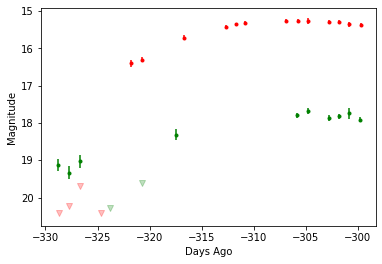

In [19]:
plot_lightcurve(dflc)

### Image cutouts

Now let's figure out how to display the cutout images.  These are gzip-compressed fits files stored as bytes:

In [20]:
packet.cutoutScience.keys()
print("packet.cutoutScience.fileName =", packet.cutoutScience.fileName)
print("packet.cutoutScience.stampData =", packet.cutoutScience.stampData[:20], "...")

packet.cutoutScience.fileName = candid739260766315010006_pid739260766315_targ_sci.fits.gz
packet.cutoutScience.stampData = b'\x1f\x8b\x08\x00S\xe56\\\x02\x03\xed\xbbgtUe\xf7\xaf\r\xa1' ...


In [52]:
stamp = packet.cutoutScience.stampData

In [53]:
type(stamp)

bytes

In [78]:
def plot_cutout(stamp, fig=None, subplot=None, **kwargs):
    with gzip.open(io.BytesIO(stamp), 'rb') as f:
        with fits.open(io.BytesIO(f.read())) as hdul:
            if fig is None:
                fig = plt.figure(figsize=(4,4))
            if subplot is None:
                subplot = (1,1,1)

            # temporarily disable nagging about WCS and vmin/vmax
            logging.getLogger("astropy").disabled = True
            ffig = aplpy.FITSFigure(hdul[0], figure=fig, subplot=subplot, **kwargs)
            ffig.show_grayscale(stretch='arcsinh')
            logging.getLogger("astropy").disabled = False
    return ffig

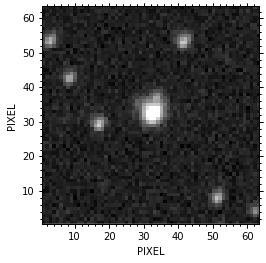

In [75]:
plot_cutout(stamp);

Now let's make a nice helper function:

In [81]:
def show_stamps(packet):
    fig = plt.figure(figsize=(12,4))
    for i, cutout in enumerate(['Science','Template','Difference']):
        stamp = packet['cutout{}'.format(cutout)].stampData
        ffig = plot_cutout(stamp, fig=fig, subplot = (1,3,i+1))
        ffig.set_title(cutout)

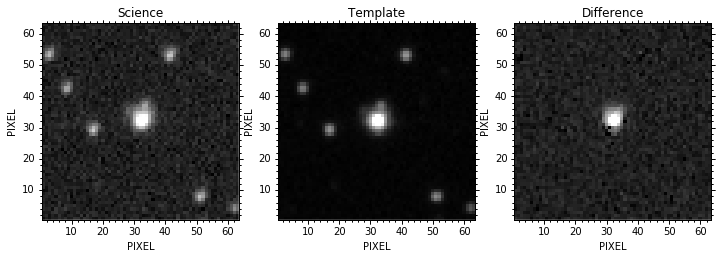

In [82]:
show_stamps(packet)